# Simple Linear Regression on Crypto

In [206]:
import pandas as pd
import yfinance as yf
from ta import add_all_ta_features
from datetime import datetime, timedelta
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import plotly.express as px
import plotly.graph_objects as go

# 1. Get Price Data

In [174]:
# Time periods
now = datetime.now()

# How far back to retrieve
ago = now - timedelta(days=1095)

# Designating the Ticker
crypto = yf.Ticker("BTC-USD")

# Getting price history
df = crypto.history(
    start=ago.strftime("%Y-%m-%d"), 
    end=now.strftime("%Y-%m-%d"), 
    interval="1d"
)

# Handling missing data from yahoo finance
df = df.reindex(
    [df.index.min()+pd.offsets.Day(i) for i in range(df.shape[0])],
    fill_value=None
).fillna(method='ffill')

# Dropping Columns
df.drop(
    ['Dividends', 'Stock Splits'], 
    axis=1,
    inplace=True
)

df

,Open,High,Low,Close,Volume
Date,,,,,
2018-10-11,6586.740234,6586.740234,6243.740234,6256.240234,5.181640e+09
2018-10-12,6239.250000,6328.500000,6236.470215,6274.580078,3.783500e+09
2018-10-13,6278.080078,6308.509766,6259.810059,6285.990234,3.064030e+09
2018-10-14,6288.490234,6363.209961,6280.149902,6290.930176,3.085320e+09
2018-10-15,6292.640137,6965.060059,6258.680176,6596.540039,7.370770e+09
...,...,...,...,...,...
2021-10-02,48137.468750,48282.062500,47465.496094,47711.488281,3.061435e+10
2021-10-03,47680.027344,49130.691406,47157.289062,48199.953125,2.663812e+10
2021-10-04,48208.906250,49456.777344,47045.003906,49112.902344,3.338317e+10


## Adding Technical Indicators

In [175]:
df = add_all_ta_features(
    df, 
    open="Open", 
    high="High", 
    low="Low", 
    close="Close", 
    volume="Volume", 
    fillna=True
)

df

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-11,6586.740234,6586.740234,6243.740234,6256.240234,5.181640e+09,-4.803969e+09,5.181640e+09,-0.927114,0.000000e+00,50.000000,...,-96.355685,0.000000,6256.240234,0.000000,0.000000,0.000000,0.000000,-65.235519,0.000000,0.000000
2018-10-12,6239.250000,6328.500000,6236.470215,6274.580078,3.783500e+09,-5.453948e+09,8.965140e+09,-0.608351,6.938880e+10,0.000000,...,-89.119861,0.000000,6260.654413,0.000000,-2.196355,-0.439271,-1.757084,0.293145,0.292716,0.293145
2018-10-13,6278.080078,6308.509766,6259.810059,6285.990234,3.064030e+09,-5.223632e+09,1.202917e+10,-0.434247,6.447055e+10,44.765863,...,-85.862330,0.000000,6266.908907,0.000000,-5.174358,-1.386288,-3.788069,0.181847,0.181682,0.475525
2018-10-14,6288.490234,6363.209961,6280.149902,6290.930176,3.085320e+09,-7.508071e+09,1.511449e+10,-0.496747,5.743780e+10,61.977801,...,-84.452006,0.000000,6273.505407,0.000000,-7.571827,-2.623396,-4.948431,0.078587,0.078556,0.554485
2018-10-15,6292.640137,6965.060059,6258.680176,6596.540039,7.370770e+09,-7.827997e+09,2.248526e+10,-0.348139,3.710295e+11,78.630615,...,-50.579901,0.000000,6378.516155,0.000000,-2.033846,-2.505486,0.471640,4.857944,4.743633,5.439366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-02,48137.468750,48282.062500,47465.496094,47711.488281,3.061435e+10,3.819146e+12,1.800293e+12,0.078539,1.911563e+13,55.072241,...,-8.377541,-2040.858490,45546.292257,11.361474,-2.040357,-1.554728,-0.485628,-0.842641,-0.846211,662.622382
2021-10-03,47680.027344,49130.691406,47157.289062,48199.953125,2.663812e+10,3.820657e+12,1.826931e+12,0.087725,1.824365e+13,61.022585,...,-9.961791,-788.801620,45674.419879,18.445808,-3.671180,-1.978019,-1.693162,1.023789,1.018584,670.430024
2021-10-04,48208.906250,49456.777344,47045.003906,49112.902344,3.338317e+10,3.844521e+12,1.860314e+12,0.072291,1.999129e+13,69.587151,...,-3.556407,500.911328,46191.975941,12.710171,-3.313671,-2.245149,-1.068522,1.894087,1.876373,685.022641


# 2. Data Transformation/Preprocessing
Changing from time-series data to tabular data.

__E.g.)__ A 10% increase in Volume _from 10 days ago to today_ leads to 10% increase in the Open price in the _next_ 10 days. 

In [176]:
# The X Variables
new_df = df.drop(
    'Open', 
    axis=1
).pct_change(
    10
).replace(
    [np.inf, -np.inf], 
    np.nan
)

# What the percent change is going to be in the next days AKA the Y Variable
new_df['future_10_days']= df['Open'].pct_change(10).shift(-10)

# Dropping Nans
new_df = new_df.dropna(
    thresh=80 # If this many NaNs exist in a row, drop the whole row
).dropna(
    axis=1,
    thresh=1000 # If this many NaNs exist in a column, drop the whole column
)

# Dropping the last NaNs from the Y variable
new_df = new_df.dropna(
    subset=['future_10_days']
)

# Filling in the rest of the NaNs with the most recent value
new_df = new_df.fillna(method='ffill').dropna()

new_df

,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,...,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,future_10_days
Date,,,,,,,,,,,,,,,,,,,,,
2018-11-17,-0.148589,-0.146677,-0.149432,-0.129139,0.731838,-1.195571,-6.674568,-7.321206,-0.287973,-1.314150,...,19.925966,-0.096228,-16.756521,7.109451,-2.375891,-0.399191,-1.355700,-1.358282,-3.562652,-0.324927
2018-11-18,-0.135126,-0.136489,-0.128636,-0.108371,0.282452,-1.059839,0.143152,-18.742255,-0.108767,-3.738225,...,140.955159,-0.104474,30.507537,2.147630,-3.020990,-0.869574,-2.064763,-2.051980,-4.203870,-0.312473
2018-11-19,-0.129433,-0.240134,-0.237116,0.619474,0.420157,-1.432700,-0.006093,52.279631,-0.287179,28.759767,...,-72.991170,-0.152890,15.349480,3.950660,-4.537247,-0.115510,11.673577,12.533147,-11.702978,-0.240496
2018-11-20,-0.230792,-0.330947,-0.305396,1.274646,0.605817,-1.725835,0.477744,258.035587,-0.498087,983.427886,...,-95.071923,-0.212389,-26.646705,25.578734,-6.988406,2.431452,-24.306859,-25.417315,-12.794812,-0.118185
2018-11-21,-0.272062,-0.315927,-0.282175,0.553701,0.657164,-1.395981,6.800963,302.982951,-0.696488,11.122607,...,-652.459534,-0.233178,-23.975436,-197.216894,-9.486397,3.705709,104.562251,102.836024,-11.669371,-0.098773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-22,-0.051467,-0.092985,-0.054029,0.367898,0.000836,-0.045259,0.974438,-0.012799,-0.251138,4.118086,...,0.493367,-0.014745,0.247032,-0.462717,-0.912999,-1.473812,2.713049,2.621603,-0.062521,0.183380
2021-09-23,-0.035548,-0.011057,-0.001512,-0.164166,0.010429,-0.005417,0.160781,-0.543252,-0.255295,-3.603828,...,0.720488,-0.010490,-0.914760,-0.723262,-0.887613,-1.219778,-2.268880,-2.235044,-0.001756,0.094575
2021-09-24,-0.045271,-0.085264,-0.090306,0.108330,0.000269,-0.048654,0.039104,1.461591,-0.335336,-2.732630,...,1.010074,-0.014271,0.544345,-0.335287,-0.812932,-1.809784,-1.966677,-2.012755,-0.104141,0.073831


# 3. Fit to Linear Model

In [190]:
# Train, test, split
X = new_df.drop('future_10_days', axis=1)

y = new_df[['future_10_days']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10
)

In [191]:
# Model object
reg = LinearRegression()

# Fitting
reg.fit(X_train, y_train)

# Getting predictions
preds = reg.predict(X_test)

## Evaluation

In [192]:
# RMSE
mean_squared_error(
    y_test, 
    preds, 
    squared=False
)

0.242748849688481

In [200]:
# Making a comparison DF
compare = pd.DataFrame()

compare['actual'] = y_test['future_10_days'].reset_index(drop=True)

compare['preds'] = preds

compare['error'] = compare['preds'] - compare['actual']

compare

,actual,preds,error
0,0.178911,0.144505,-0.034406
1,0.042167,0.146410,0.104243
2,-0.083701,0.265710,0.349411
3,0.065387,0.029563,-0.035825
4,0.054576,0.395984,0.341408
...,...,...,...
100,-0.067583,0.038900,0.106483
101,0.152131,0.065970,-0.086161
102,0.072305,0.036001,-0.036304
103,0.036032,0.025097,-0.010935


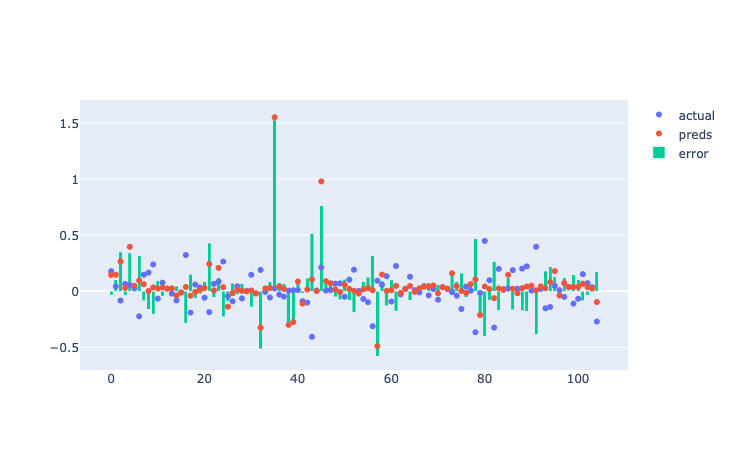

In [214]:
# Visualizing results
fig = go.Figure()

# fig = px.scatter(
#     compare,
#     x=compare.index,
#     y=['actual', 'preds'],
#     title='Actual vs. Prediction',
#     labels={}
# )
# Add traces
fig.add_trace(go.Scatter(x=compare.index, y=compare['actual'],
                    mode='markers',
                    name='actual'))
fig.add_trace(go.Scatter(x=compare.index, y=compare['preds'],
                    mode='markers',
                    name='preds'))
fig.add_trace(go.Bar(x=compare.index, y=compare['error'],
                    name='error'))

fig.show()